<a href="https://colab.research.google.com/github/geopayme/AstroPhysics/blob/main/DLSFH_Entropy_Diagnostic_NOAA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌞 DLSFH Entropy Full Diagnostic Notebook (with Real NOAA Data)
This notebook:
1. Extracts entropy from solar magnetogram
2. Projects SGCV coherence states (ψₛ, ψₛ★)
3. Overlays real NOAA Solar Cycle 25 sunspot data for validation


In [1]:
# 📤 Upload solar magnetogram image
from google.colab import files
uploaded = files.upload()
image_path = next(iter(uploaded))
print(f'🖼️ Using image: {image_path}')

Saving bbzqa250328t0004_dim-860.jpg to bbzqa250328t0004_dim-860.jpg
🖼️ Using image: bbzqa250328t0004_dim-860.jpg


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import sobel, generic_filter
import os, re
from datetime import datetime
import matplotlib.dates as mdates
from dateutil.relativedelta import relativedelta
import pandas as pd

In [3]:
# 🧠 Load and process image to generate entropy map
img = Image.open(image_path).convert('L')
img_array = np.array(img)
h, w = img_array.shape
cx, cy = w // 2, h // 2
radius = min(cx, cy) - 10
y_idx, x_idx = np.ogrid[:h, :w]
mask = (x_idx - cx)**2 + (y_idx - cy)**2 <= radius**2

gradient_x = sobel(img_array, axis=1)
gradient_y = sobel(img_array, axis=0)
magnitude = np.hypot(gradient_x, gradient_y)
local_var = generic_filter(img_array.astype(float), np.var, size=11)

grad_norm = (magnitude - np.min(magnitude)) / (np.ptp(magnitude) + 1e-8)
var_norm = (local_var - np.min(local_var)) / (np.ptp(local_var) + 1e-8)
entropy_map = (grad_norm + var_norm) / 2.0
entropy_map[~mask] = 0

In [4]:
# 🧩 DLSFH 20-node entropy vector + SGCV projection
angles = np.linspace(0, 2 * np.pi, 21)
radii = [0.3, 0.65]
zones = [(int(cx + r * radius * np.cos((angles[i]+angles[i+1])/2)),
          int(cy + r * radius * np.sin((angles[i]+angles[i+1])/2)))
         for r in radii for i in range(10)]
kernel = 20
vector = np.array([
    np.mean(entropy_map[max(0, y-kernel):min(h, y+kernel), max(0, x-kernel):min(w, x+kernel)])
    for x, y in zones
])
threshold = 0.07
phases = np.where(vector >= threshold, 'ψₛ★', 'ψₛ')

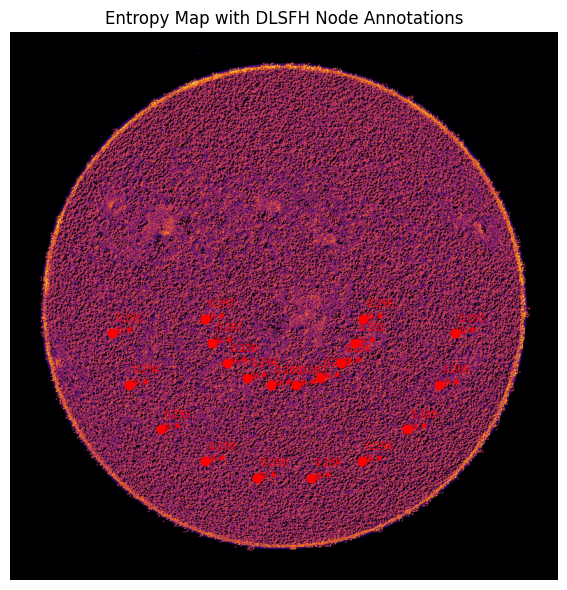

In [5]:
# 🗺️ Annotated entropy map
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(entropy_map, cmap='inferno')
for i, (x, y) in enumerate(zones):
    color = 'red' if vector[i] >= threshold else 'blue'
    label = f'{vector[i]:.3f}\n{phases[i]}'
    ax.plot(x, y, 'o', color=color)
    ax.text(x+5, y, label, fontsize=7, color=color)
ax.set_title('Entropy Map with DLSFH Node Annotations')
ax.axis('off')
plt.tight_layout()
plt.show()

In [6]:
# 📊 Load real NOAA Solar Cycle 25 data
sunspot_df = pd.read_csv('noaa_solar_cycle25_sunspots.csv')
sunspot_df['date'] = pd.to_datetime(sunspot_df['date'])

In [7]:
# ⏱️ Match image date
try:
    match = re.search(r'(\d{2})(\d{2})(\d{2})t', image_path)
    yr, mo, dy = match.groups()
    year_full = int('20' + yr) if int(yr) < 50 else int('19' + yr)
    image_date = datetime(year_full, int(mo), int(dy))
except:
    image_date = datetime(2025, 3, 28)

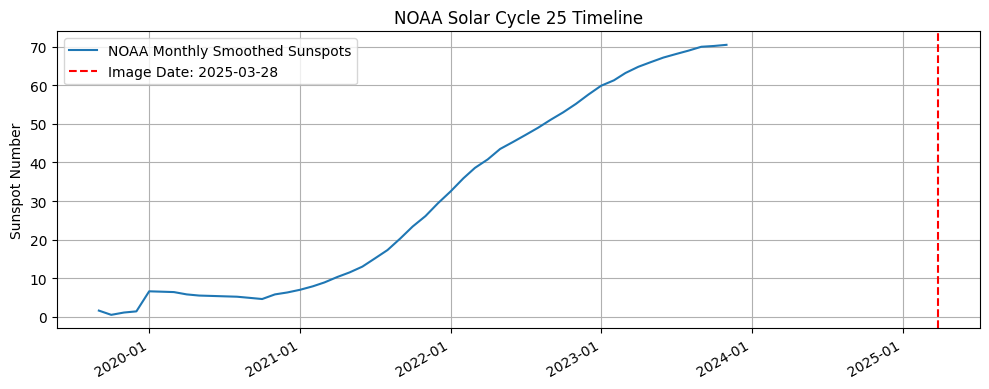

In [8]:
# 📈 NOAA solar cycle plot
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(sunspot_df['date'], sunspot_df['sunspots'], label='NOAA Monthly Smoothed Sunspots')
ax.axvline(image_date, color='red', linestyle='--', label=f'Image Date: {image_date.date()}')
ax.set_title('NOAA Solar Cycle 25 Timeline')
ax.set_ylabel('Sunspot Number')
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
fig.autofmt_xdate()
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
# 🧠 SGCV-DLSFH Diagnostic Output
print('=== Final Coherence Diagnosis ===')
print(f'Date: {image_date.date()}')
print(f'Mean Entropy: {np.mean(vector):.4f} | Std: {np.std(vector):.4f}')
print(f'Collapsed (ψₛ★): {np.sum(phases == "ψₛ★")} / 20')
if np.all(phases == 'ψₛ★'):
    print('🔥 Full collapse — magnetic reversal or maximum likely.')
elif np.any(phases == 'ψₛ★'):
    print('⚠️ Partial decoherence — transitional surface flux.')
else:
    print('✅ Stable coherence state — low or rising cycle phase.')

=== Final Coherence Diagnosis ===
Date: 2025-03-28
Mean Entropy: 0.2915 | Std: 0.0063
Collapsed (ψₛ★): 20 / 20
🔥 Full collapse — magnetic reversal or maximum likely.
